## Independent genomewide screens identify the tumor suppressor VTRNA2-1 as a human epiallele responsive to periconceptional environment

# 1. Configure the same software tools and versions used. 
#### To do this .bash_rc file from /home/jduryea will be used

##### The following output shows the .bash_rc paths that will be used for this analysis. This should render the output exactly similar to Jack's sample output file for CO1_HF_lane1


```bash
export PATH=$PATH:/home/noahk/bin/
export PATH=$PATH:/home/noahk/bin/
export PATH=$PATH:/home/jdong/miniconda2/bin
export PATH=$PATH:/home/jdong/bismark_v0.16.3
export PATH=$PATH:/home/noahk/software/cutadapt-1.8.3/bin
export PATH=$PATH:/home/jdong/sratoolkit.2.8.1-centos_linux64/bin
export PATH=$PATH:/home/noahk/jduryea/samstat-1.5.1/bin
export PATH=$PATH:/home/coarfa/pkgs/java/bin
export PATH=$PATH:/home/noahk/software/picard/bin
export PATH=$PATH:/home/coarfa/pkgs/java/picard/picard.jar
export PATH=$PATH:/home/coarfa/pkgs/picardtools-2.9.0/picard.jar
export PATH=$PATH:/home/coarfa/pkgs/picard/picard.jar
export JAVA_HOME=/home/coarfa/pkgs/java
export PATH=$JAVA_HOME/bin:$PATH
export PATH=$PATH:/home/coarfa/pkgs/picardtools-2.9.0
export PATH=$PATH:/home/coarfa/pkgs/java/picard
export PATH=$PATH:/home/jduryea/trim_galore_v0.4.4
export PATH=$PATH:/home/jduryea
export PATH=$PATH:/home/noahk/software/FastQC/bin
export PATH=$PATH:/home/noahk/software/trim_galore_v0.4.4
export PATH=$PATH:/home/jduryea/bin/bamtools/bin
export PATH=$PATH:/home/jduryea/bin/biscuit-release
export PATH=$PATH:~/.local/bin
```

# 2. Download data from SRA

The Gene Expression Omnibus (GEO) accession number for the raw sequence reads for the four Bisulfite-seq libraries is GSE44806.

- --split-files: This option in the fastq-dump tool, split the SRA file in to fastq file with read1.fq and read2.fq


```bash
#!/bin/sh

#SBATCH --time=24:00:00
#SBATCH -n4
#SBATCH -p dque

starttime=$(date +"%s")
echo $(date -u -d @${starttime})
echo "options: --time=24:00:00 -n4 -p dque"
echo "$0"

for i in 1 2 3 4 5 6 7 8 9
do
    ftp://ftp-trace.ncbi.nlm.nih.gov/sra/sra-instant/reads/ByExp/sra/SRX/SRX248/SRX248434/SRR77140"${i}"/SRR77140"${i}".sra
    fastq-dump --split-files SRR77140"${i}".sra
done

for i in 10 11 12
do
    ftp://ftp-trace.ncbi.nlm.nih.gov/sra/sra-instant/reads/ByExp/sra/SRX/SRX248/SRX248434/SRR7714"${i}"/SRR7714"${i}".sra
    fastq-dump --split-files SRR7714"${i}".sra
done

endtime=$(date +"%s")
echo $(date -u -d @${endtime})
echo "Time elapsed" $(date -u -d @$(($endtime-$starttime)) +"%T")
```

## For the demonstration and comparison  SRR771401.fastq file will be used.

# 3. Quality control using trim_galore software

Trim Galore! is a wrapper script to automate quality and adapter trimming as well as quality control.
This software automatically
- removes base calls with a Phred score of 20 or lower (assuming Sanger encoding)
- removes any signs of the Illumina adapter sequence from the 3' end (AGATCGGAAGAGC)
- removes sequences that got shorter than 20 bp


 ```bash
#!/bin/sh

#SBATCH --time=24:00:00
#SBATCH -n4
#SBATCH -p dque

starttime=$(date +"%s")
echo $(date -u -d @${starttime})
echo "options: --time=24:00:00 -n4 -p dque"
echo "$0"

trim_galore --paired --trim1 SRR771401_1.fastq SRR771401_2.fastq

endtime=$(date +"%s")
echo $(date -u -d @${endtime})
echo "Time elapsed" $(date -u -d @$(($endtime-$starttime)) +"%T")
```

# 4. Using Bismark to map to the reference genome

**Note that different versions of the human genome file can introduce differences. So use the same file used by Jack**

-**Location of the processed human genome used by Jack :**
/home/jduryea/genomes/homo_sapiens/hg38

### 4.1 To prepare a new reference genome to be used by bismark following shell script can be used.
The downloaded referece genome (.fa) should be in the same directory where this shell script is called from.

```bash
#!/bin/sh

#SBATCH --time=100:00:00
#SBATCH -n4
#SBATCH -p longjob

starttime=$(date +"%s")
echo $(date -u -d @${starttime})
echo "options: --time=100:00:00 -n4 -p longjob"
echo "$0"

bismark_genome_preparation ./

endtime=$(date +"%s")
echo $(date -u -d @${endtime})
echo "Time elapsed" $(date -u -d @$(($endtime-$starttime)) +"%T")
```


### 4.2 Mapping reads to referece genome using Bismark

 Description of the parameters used:
 
- -q : The query input files (specified as <mate1>,<mate2> or <singles> are FASTQ files (usually having extension .fg or .fastq). This is the default.
 
- --bowtie2 : Default: ON. Uses Bowtie 2 instead of Bowtie 1. Bismark limits Bowtie 2 to only perform end-to-end alignments, i.e. searches for alignments involving all read characters (also called untrimmed or unclipped alignments). Bismark assumes that raw sequence data is adapter and/or quality trimmed where appropriate. Both small (.bt2) and large (.bt2l) Bowtie 2 indexes are supported.
 
- -p : This options if to paralleliztion of bowtie2
 
- [genome folder] in this example, the pathe to the genome folder used by Jack is given.

- -B : The base name of the .BAM file generated from the Bismark.
- --multicore : this option works when -B is not specified. Use this to set the programm to run in parallel.
- -1: read 1 fastq file
- -2: read 2 fastq file

- ** Note that, if you are planning to use bisSNP later, add the --rg_tag to bismark. The the read groups will be tagged with some information about the sequecing for later use.

 


```bash
#!/bin/sh

#SBATCH --time=48:00:00
#SBATCH -n4
#SBATCH -p dque

starttime=$(date +"%s")
echo $(date -u -d @${starttime})
echo "options: --time=48:00:00 -n4 -p dque"
echo "$0"

bismark -q --bowtie2 -p 4 /home/jduryea/genomes/homo_sapiens/hg38 -B C01_HF_lane1 -1 SRR771401_1.qc.fastq -2 SRR771401_2.qc.fastq

endtime=$(date +"%s")
echo $(date -u -d @${endtime})
echo "Time elapsed" $(date -u -d @$(($endtime-$starttime)) +"%T")
```

### 4.3 Splitting tha bam file to extract only the Chr 19 bam file to demonstrate the output using split_bam software tool


```bash

#!/bin/sh

#SBATCH --time=48:00:00
#SBATCH -n4
#SBATCH -p dque

starttime=$(date +"%s")
echo $(date -u -d @${starttime})
echo "options: --time=48:00:00 -n4 -p dque"
echo "$0"

split_bam C02_HF_lane1_pe.bam

endtime=$(date +"%s")
echo $(date -u -d @${endtime})
echo "Time elapsed" $(date -u -d @$(($endtime-$starttime)) +"%T")

```

This generates lots of files including one for chromosome and other scaffoldings ect. **Just take the chr19 bam file** and used for furether processing.

- The following file is used C01_HF_lane1_pe.REF_chr19.bam


# 5. Methylation extraction using bismark_methylation_extractor

** Potentiall important consideration**
--no_overlap

For paired-end reads it is theoretically possible that Read 1 and Read 2 overlap. This option avoids scoring overlapping methylation calls twice (only methylation calls of read 1 are used for in the process since read 1 has historically higher quality basecalls than read 2). 

This is set automatically by the methylation extractor.

```bash

#!/bin/sh

#SBATCH --time=24:00:00
#SBATCH -n4
#SBATCH -p dque

starttime=$(date +"%s")
echo $(date -u -d @${starttime})
echo "options: --time=24:00:00 -n4 -p dque"
echo "$0"

bismark_methylation_extractor -p --comprehensive --report --multicore 4 --samtools_path /home/noahk/software/samtools-1.2 --bedGraph --buffer_size 8G --ample_memory --cytosine_report --genome_folder  /home/jduryea/genomes/homo_sapiens/hg38 C01_HF_lane1_pe.REF_chr19.bam

endtime=$(date +"%s")
echo $(date -u -d @${endtime})
echo "Time elapsed" $(date -u -d @$(($endtime-$starttime)) +"%T")

```

### The methylation extractor produces a coverge file as shown in the sample below.

In [35]:
import pandas as pd
filename = "./sanity_check/C01_HF_chr19_1.bismark.cov"
df_cov = pd.read_table(filename,header=None)
df_cov.columns = ['Chromosome','Position','End','Perc','Methylated','Unmethylated']

In [36]:
df_cov.iloc[0:10]

,Chromosome,Position,End,Perc,Methylated,Unmethylated
0,chr19,61198,61198,100.000000,3,0
1,chr19,61291,61291,100.000000,8,0
2,chr19,61380,61380,66.666667,2,1
3,chr19,61396,61396,100.000000,3,0
4,chr19,61496,61496,100.000000,1,0
5,chr19,61835,61835,0.000000,0,1
6,chr19,61842,61842,0.000000,0,1
7,chr19,61861,61861,0.000000,0,1
8,chr19,62198,62198,100.000000,1,0
9,chr19,62748,62748,0.000000,0,1


### Position
The Position indicate the start location of the methylated citosine base (CG) in chromose-wise (by default). There is an option in methylation extractor to specify otherwise. (Check if this is correct ?)

### End
The end position of the citosine base. Its the same as the start because its one base.

### Methylation Percentage
This percentage represent the actual read coverage of detected methylated or unmethylated reads at a position.


### count methylated
out of the aligned reads, how many reads say its methylated CG

### count unmethylated
out of the aligned reads, how many reads says its unmethylated CG



# 6. (Optional) Control for the read depth

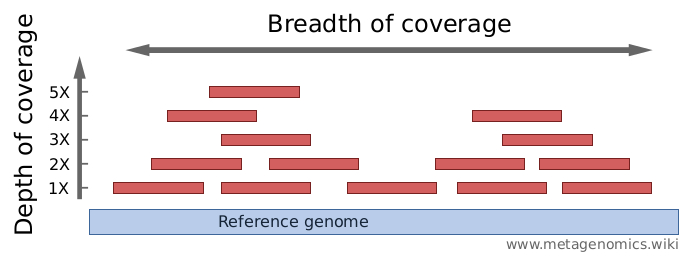

In [37]:
from IPython.display import Image                        
url='http://www.metagenomics.wiki/_/rsrc/1479665634459/pdf/definition/coverage-read-depth/coverage_breadth_depth.png'
Image(url,width=700, height=300)


The follwing shell script is used to select methylated cytosine bases that have at least covered by 10 reads. This will be set as a variable in the final bining script.

```bash
awk '$5 + $6 >=10' C01_HF_1_chr19.bismark.cov > C01_HF_1_chr19.bismark.rd.cov

```

### After controling for Depth of Coverage

In [38]:
import pandas as pd
filename = "./sanity_check/C01_HF_chr19_1.bismark.cov"
df_cov = pd.read_table(filename,header=None)
df_cov.columns = ['Chromosome','Position','End','Perc','Methylated','Unmethylated']
df_cov.iloc[0:10]

,Chromosome,Position,End,Perc,Methylated,Unmethylated
0,chr19,61198,61198,100.000000,3,0
1,chr19,61291,61291,100.000000,8,0
2,chr19,61380,61380,66.666667,2,1
3,chr19,61396,61396,100.000000,3,0
4,chr19,61496,61496,100.000000,1,0
5,chr19,61835,61835,0.000000,0,1
6,chr19,61842,61842,0.000000,0,1
7,chr19,61861,61861,0.000000,0,1
8,chr19,62198,62198,100.000000,1,0
9,chr19,62748,62748,0.000000,0,1


# 7. Binning of cytosine to user difined bin width (e.x: 200bp)

**The rest of the pipeline does not assumen filtered for read depth.

In [39]:
from operator import add
import numpy as np
import os
import sys
from collections import defaultdict
bin_size = 200

df_cov = df_cov.iloc[:,-6:]

df_cov = df_cov.sort_values(['Chromosome', 'Position'], ascending=[True, True])

df_cov = df_cov.reset_index(drop=True)

Create a dictionary (bin_coverage) to hold the number of methylated cytosines in each bin.

    - Dictionary key: A unique bin number calculated for each bin

    - Dictionary value: Incremental value, as the coverage file is parsed if cytosine positions are found within the bin range, the count increase one by one.

In [40]:
bin_coverage = defaultdict(lambda:0)


Create a dictionary (bin_data) to hold the methylated and unmethylated counts for each cytosine witing the bin range. All the methylated counts will be added together and unmethylated count will be added together.

    - Dictionary Key: A unique bin number calculated for each bin
    
    - Dictionary value: A list with two values first is the sum of methylated counts and second is sum of unmethylated counts

In [41]:
bin_data = defaultdict(lambda:[0,0])

## For example, lets creat the first bin;

In [42]:
# extract the first line from the coverage file
line = df_cov.iloc[0]
print(line)

Chromosome      chr19
Position        61198
End             61198
Perc              100
Methylated          3
Unmethylated        0
Name: 0, dtype: object


In [43]:
# Extract informatin as follows,
chrm_name = str(line["Chromosome"])
start = int(line["Position"])
end = int(line["End"])
num_methylated_reads = line["Methylated"]
num_unmethylated_reads = line["Unmethylated"]

In [44]:
bin_number = (start-1)//bin_size # Using integer division is the key here
print (bin_number)

305


In [45]:
bin_label = (bin_number*bin_size) + bin_size
print (bin_label)

61200


This creates the first bin.

Then get the second row and the integer division result in getting same bin_label if within the 200 bp bin.

In [46]:
bin_data[bin_label] = list(map(add, bin_data[bin_label], [num_methylated_reads,num_unmethylated_reads]))
bin_coverage[bin_label] += 1

In [47]:
bin_data.items()

dict_items([(61200, [3, 0])])

In [48]:
bin_coverage.items()

dict_items([(61200, 1)])

Details about generating a unique binning label using the methylated cytosine positions are shown below.
```bash

read the next line from the cov file
    if CG belongs to the first bin 
        then add to that bin. 
    else 
        create the next bin.
        
 Do this for all lines in the coverage file.
 
 ```

```bash
example,
10 => (10-1)//3 => 3
11 => (11-1)//3 => 3
12 => (12-1)//3 => 3
so 10,11,12 will be in bin 3.
13 => (13-1)//3 => 4

to get the bin label,
(bin_num(3) * bin_width(3)) + bin_width(3)
12 => this lable is used to group (10,11,12) together
```

In [49]:
for index, line in df_cov.iterrows():
    # Split line into components
    chrm_name = str(line["Chromosome"])
    start = int(line["Position"])
    end = int(line["End"])

    num_methylated_reads = line["Methylated"]
    num_unmethylated_reads = line["Unmethylated"]

    bin_number = (start-1)//bin_size # Using integer division is the key here
    bin_label = (bin_number*bin_size) + bin_size

    bin_data[bin_label] = list(map(add, bin_data[bin_label], [num_methylated_reads,num_unmethylated_reads]))
    bin_coverage[bin_label] += 1

In [50]:
i=0
for k,v in bin_data.items():
    i=i+1
    if (i == 6):
        break
    print ("%s - %s" % (str(k), str(v)))

61200 - [6, 0]
61400 - [13, 1]
61600 - [1, 0]
62000 - [0, 3]
62200 - [1, 0]


In [51]:
i=0
for k,v in bin_coverage.items():
    i=i+1
    if (i == 6):
        break
    print ("%s - %s" % (str(k), str(v)))

61200 - 2
61400 - 3
61600 - 1
62000 - 3
62200 - 1


In [52]:

coords = []
bin_names = []
methylations = []
cpgs_covered = []

# Append bin data do lists so we can add them to the data frame
sorted_keys = list(bin_data.keys())
sorted_keys.sort()

For each bin, calculate the coordinte for USCS GBrowser and percentage of average methylation.

In [53]:
#for _bin in sorted_keys:
# Caclucate Coordinates
_bin = sorted_keys[0]
bin_name = chrm_name + "_" + str(_bin)
bin_start_loc = _bin - bin_size
bin_end_loc = _bin
UCSC_browser_coordinates = chrm_name + ":" + str(bin_start_loc) + "-" +  str(bin_end_loc)

print(bin_name,bin_start_loc,bin_end_loc,UCSC_browser_coordinates)


chr19_61200 61000 61200 chr19:61000-61200


In [54]:
# Calculate Methylation percentage
bin_methylation_data = bin_data[_bin]
print(bin_methylation_data)
avg_methylation = 0
if bin_methylation_data[0]+bin_methylation_data[1] != 0: # Denominator is not 0
    avg_methylation  = 100.0*bin_methylation_data[0]/(bin_methylation_data[0]+bin_methylation_data[1])
print(avg_methylation)

[6, 0]
100.0


In [55]:
bin_coverage[_bin]

2

Now, lets do this for all bins.

In [56]:

sorted_keys = list(bin_data.keys())
sorted_keys.sort()
for _bin in sorted_keys:

    # Coordinates
    bin_name = chrm_name + "_" + str(_bin)
    bin_start_loc = _bin - bin_size
    bin_end_loc = _bin
    UCSC_browser_coordinates = chrm_name + ":" + str(bin_start_loc) + "-" +  str(bin_end_loc)

    # Methylation percentage
    bin_methylation_data = bin_data[_bin]
    avg_methylation = 0
    if bin_methylation_data[0]+bin_methylation_data[1] != 0: # Denominator is not 0
        avg_methylation  = 100.0*bin_methylation_data[0]/(bin_methylation_data[0]+bin_methylation_data[1])

    # Append data to lists
    coords.append(UCSC_browser_coordinates)
    bin_names.append(bin_name)
    methylations.append(avg_methylation)
    cpgs_covered.append(bin_coverage[_bin])


In [57]:
dataframe_data = {"UCSC Browser Coordinates":coords,"Bin Name":bin_names,"Avg Methylation":methylations,"CpGs Covered":cpgs_covered}
df = pd.DataFrame.from_dict(dataframe_data)
rearranged_cols = ["UCSC Browser Coordinates","Bin Name","Avg Methylation","CpGs Covered"]
df = df.reindex_axis(rearranged_cols, axis=1)

In [58]:
df.iloc[0:10]

,UCSC Browser Coordinates,Bin Name,Avg Methylation,CpGs Covered
0,chr19:61000-61200,chr19_61200,100.000000,2
1,chr19:61200-61400,chr19_61400,92.857143,3
2,chr19:61400-61600,chr19_61600,100.000000,1
3,chr19:61800-62000,chr19_62000,0.000000,3
4,chr19:62000-62200,chr19_62200,100.000000,1
5,chr19:62600-62800,chr19_62800,0.000000,1
6,chr19:62800-63000,chr19_63000,81.818182,5
7,chr19:63000-63200,chr19_63200,85.294118,3
8,chr19:63200-63400,chr19_63400,80.000000,5
9,chr19:63400-63600,chr19_63600,100.000000,1


### 7.1 (Optional) Control for the number of CpG in each bin

Based on reqirement a filter will be applied here to remove bins which has less than the user specified number of CpGs(ex.2)

In [59]:
CpG_cov = 2
df_filterd = df[(df['CpGs Covered']>CpG_cov)]

In [77]:
df.to_csv("./sanity_check/C01_HF_chr19_1_Chathura.csv",header= True)

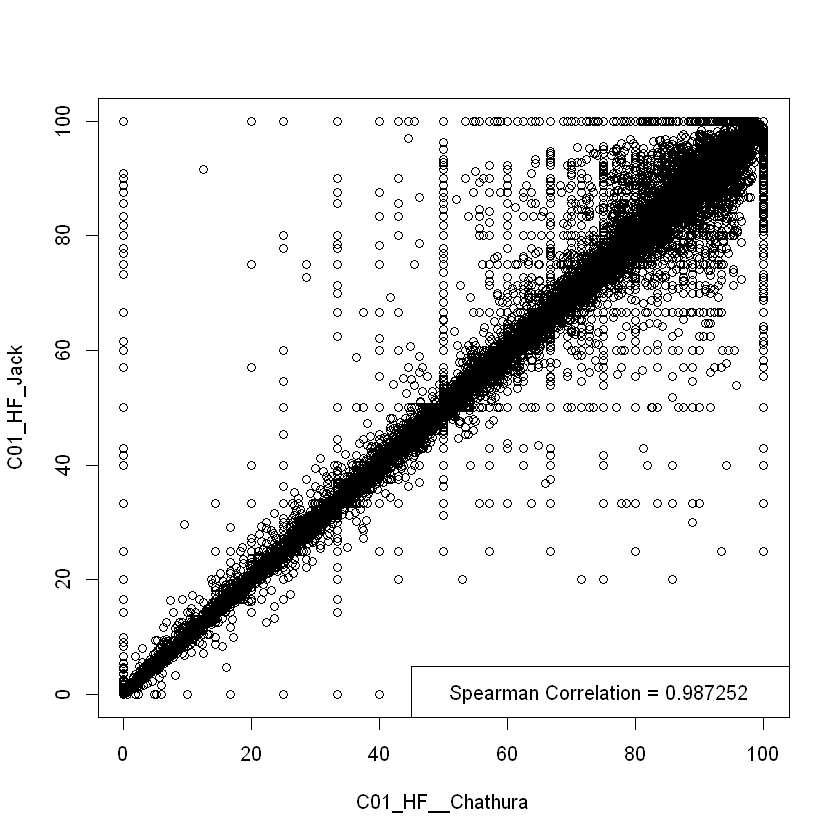

In [17]:
library(ggplot2)

#Coveravge file: chromosome", "position", "strand", "methylation percentage", "count methylated", "count unmethylated

C01_HF_jack<-read.csv("./sanity_check/C01_HF_chr19_lane1_bins.csv")
C01_HF_Chathura <- read.csv("./sanity_check/C01_HF_chr19_1_Chathura.csv")

C01_HF_merge <- merge(C01_HF_Chathura,C01_HF_jack,by = "Bin.Name")
plot(C01_HF_merge$Avg.Methylation.x,C01_HF_merge$Avg.Methylation.y,xlab="C01_HF__Chathura",ylab="C01_HF_Jack")
legend(x='bottomright', legend=paste('Spearman Correlation =',round(cor(C01_HF_merge$Avg.Methylation.x,C01_HF_merge$Avg.Methylation.y),6)))

